In [8]:
import numpy as np 
import pandas as pd 
from scipy.stats import beta, bernoulli, norm 
from scipy.special import softmax

# torch 
import torch

# visualizatioion pkg 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format='retina'

import sys 
sys.path.append("..") 
from utils.viz import viz 
viz.get_style()

eps_ = 1e-13
max_ = 1e+13

# The new RL rule

### 1. Create the probability learning task

In [2]:
def get_data(n_trials=300):
    p_blue = np.zeros( n_trials)
    for i in range(n_trials):
        if i<120:
            p_blue[i] = 0.75
        elif i<160:
            p_blue[i] = 0.2
        elif i<200:
            p_blue[i] = 0.8
        elif i<230:
            p_blue[i] = 0.2
        elif i<260:
            p_blue[i] = 0.8
        else:
            p_blue[i] = 0.2
    blue_seen = np.zeros(n_trials)
    for i in range(n_trials):
        rand=np.random.rand(1)
        if rand < p_blue[i]:
            blue_seen[i] = 1

    sim_data = {'state': blue_seen, 'p_True': p_blue, 'trials': range(n_trials)}
    
    return pd.DataFrame.from_dict(sim_data)

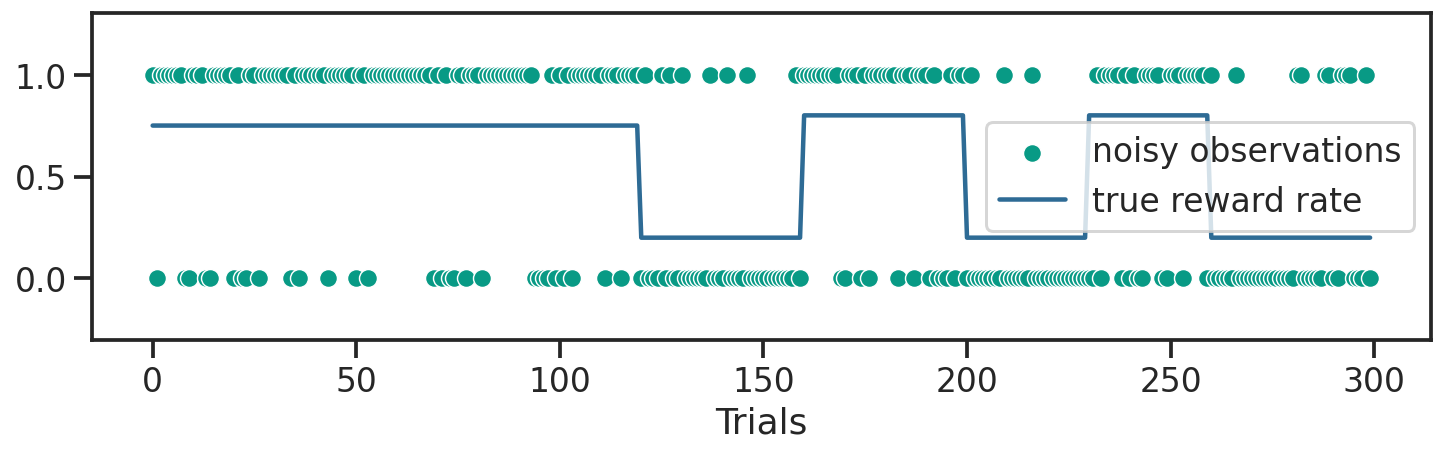

In [3]:
block_data = get_data()
fig,ax=plt.subplots(1,1,figsize=(12, 3))
sns.scatterplot(x=range(block_data.shape[0]), y='state', data=block_data, 
            marker='o', color=viz.Green, 
            ax=ax, label='noisy observations')
sns.lineplot(x=range(block_data.shape[0]), y='p_True', data=block_data, 
            color=viz.Blue, 
            ax=ax, label='true reward rate')
ax.set_ylim([-.3, 1.3])
ax.set_ylabel('')
ax.set_xlabel('Trials')
ax.legend()
plt.show()

### 1. The classic RL model

Let $o_t$ is the feedback, $p$ is the prediction. The loss function of the class RL model.

$$\min_p L(p) = \frac{1}{2}(o_t - p)^2$$

The gradient of $\bigtriangledown_p L(p) = -(o_t - p)$. Thus, the classic RL model's update rule is,

$$p = p + \alpha(o_t - p)$$

In [4]:
class model:

    def __init__(self, agent, param_priors=None):
        self.agent = agent
        self.param_priors = param_priors

    # ------------ simulate ------------ #

    def sim(self, data, params, rng):
        sim_data = [] 
        for block_id in data.keys():
            block_data = data[block_id].copy()
            sim_data.append(self.sim_block(block_data, params, rng))
        
        return pd.concat(sim_data, ignore_index=True)

    def sim_block(self, block_data, params, rng):

        ## init the agent 
        nA = block_data['state'].unique().shape[0]
        subj = self.agent(nA, params)

        ## init a blank dataframe to store simulation
        col = ['act', 'rew', 'acc', 'logLike'] + [
                f'{v}_pred' for v in self.agent.voi]
        init_mat = np.zeros([block_data.shape[0], len(col)]) + np.nan
        pred_data = pd.DataFrame(init_mat, columns=col)  

        ## loop to simulate the responses in the block
        for t, row in block_data.iterrows():

            # predict stage: obtain input
            corAct  = int(row['state'])

            # control stage: make a resposne
            logLike = subj.control(corAct, mode='eval')
            act, logAcc = subj.control(corAct, rng=rng)
            rew = 1 * (int(1-act)==corAct)

            # record the vals 
            pred_data.loc[t, 'act']     = act
            pred_data.loc[t, 'rew']     = rew
            pred_data.loc[t, 'acc']     = np.exp(logAcc).round(3)
            pred_data.loc[t, 'logLike'] = -logLike.round(3)

            # record some important variable
            for var in self.agent.voi:
                pred_data.loc[t, f'{var}_pred'] = eval(f'subj.print_{var}()')

            # feedback stage: update the belief, gen has no feedback
            mem = {'corAct': corAct, 'act': act, 'rew': rew}
            subj.buffer.push(mem)  
            subj.learn() 

        # remove all nan columns
        pred_data = pred_data.dropna(axis=1, how='all')

        return pd.concat([block_data, pred_data], axis=1)

In [5]:
class simpleBuffer:
    '''Simple Buffer 2.0
    Update log: 
        To prevent naive writing mistakes,
        we turn the list storage into dict.
    '''
    def __init__(self):
        self.m = {}
        
    def push(self, m_dict):
        self.m = { k: m_dict[k] for k in m_dict.keys()}
        
    def sample(self, *args):
        lst = [self.m[k] for k in args]
        if len(lst)==1: return lst[0]
        else: return lst

class baseAgent:
    '''Base model for all'''
    name     = 'base'
    n_params = 0
    bnds     = []
    pbnds    = []
    p_name   = []
    n_params = 0
    voi      = [] 

    def __init__(self, nA, params):
        self.nA = nA 
        self.load_params(params)
        self._init_Believes() 
        self._init_Buffer() 

    def load_params(self, params): 
        return NotImplementedError

    def _init_Buffer(self):
        self.buffer = simpleBuffer()

    def _init_Believes(self):
        self._init_Critic()

    def _init_Critic(self):
        self.p_A = np.ones([self.nA,]) / 2

    def learn(self): 
        return NotImplementedError

    def _policy(self): 
        return NotImplementedError

    def control(self, a, rng=None, mode='sample'):
        '''control problem 
            mode: -'get': get an action, need a rng 
                  -'eval': evaluate the log like 
        '''
        p_A = self._policy() 
        if mode == 'eval': 
            return np.log(p_A[a]+eps_)
        elif mode == 'sample': 
            return rng.choice(range(self.nA), p=p_A), np.log(p_A[a]+eps_)

In [6]:
class classRL(baseAgent):
    '''Classic model in Browning 2015'''
    name     = 'classic RL'
    bnds     = [(0, 60)]
    pbnds    = [(0, 60)]
    p_name   = ['α']
    n_params = len(bnds)
    voi      = ['p'] 

    def load_params(self, params): 
        self.alpha = params[0]

    def _init_Critic(self):
        self.p = 1/self.nA 
        self.p_A = np.ones([self.nA,]) / self.nA

    def learnCritic(self):
        o =  self.buffer.sample('corAct')
        self.p   += self.alpha*(o - self.p)
        self.p_A = np.array([self.p, 1-self.p])

    def learn(self):
        self.learnCritic()

    def _policy(self):
        return self.p_A

    def print_p(self):
        return self.p
    

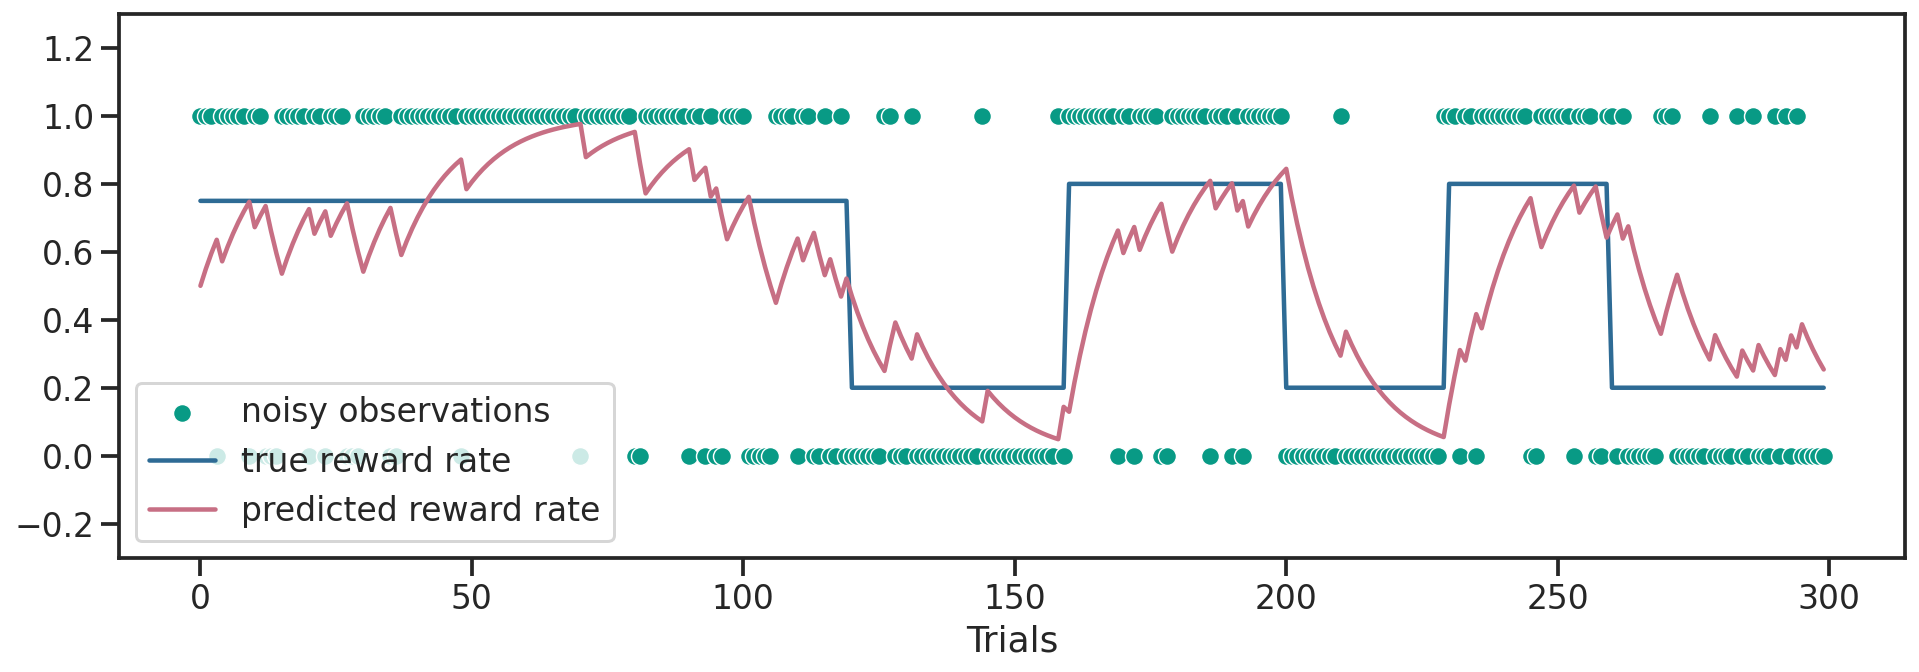

In [67]:
subj_data = {1: get_data()}
rng = np.random.default_rng(42)
subject = model(classRL)

params = [.1]
sim_data = subject.sim(subj_data, params, rng)
fig,ax=plt.subplots(1,1,figsize=(16, 5))
sns.scatterplot(x='trials', y='state', data=sim_data, 
            marker='o', color=viz.Green, 
            ax=ax, label='noisy observations')
sns.lineplot(x='trials', y='p_True', data=sim_data, 
            color=viz.Blue, 
            ax=ax, label='true reward rate')
sns.lineplot(x='trials', y='p_pred', data=sim_data, 
            color=viz.Red, 
            ax=ax, label='predicted reward rate')
ax.set_ylim([-.3, 1.3])
ax.set_ylabel('')
ax.set_xlabel('Trials')
ax.legend()
plt.show()

## Minimize KL

In [57]:
class minKL(baseAgent):
    name     = 'classic RL'
    bnds     = [(0, 60)]
    pbnds    = [(0, 60)]
    p_name   = ['α']
    n_params = len(bnds)
    voi      = ['p'] 

    def load_params(self, params): 
        self.alpha = params[0]
    
    def _init_Believes(self):
        self._init_Actor()

    def _init_Actor(self):
        self.theta = 0
        self.p = 1 / (1 + np.exp(-self.theta))
        self.pi_A = np.array([self.p, 1-self.p])

    def learnActor(self):
        o =  self.buffer.sample('corAct')
        self.theta -= self.alpha*(self.p - o)
        self.p = 1 / (1 + np.exp(-self.theta))
        self.pi_A = np.array([self.p, 1-self.p])
        
    def learn(self):
        self.learnActor()

    def _policy(self):
        return self.pi_A

    def print_p(self):
        return self.p
    

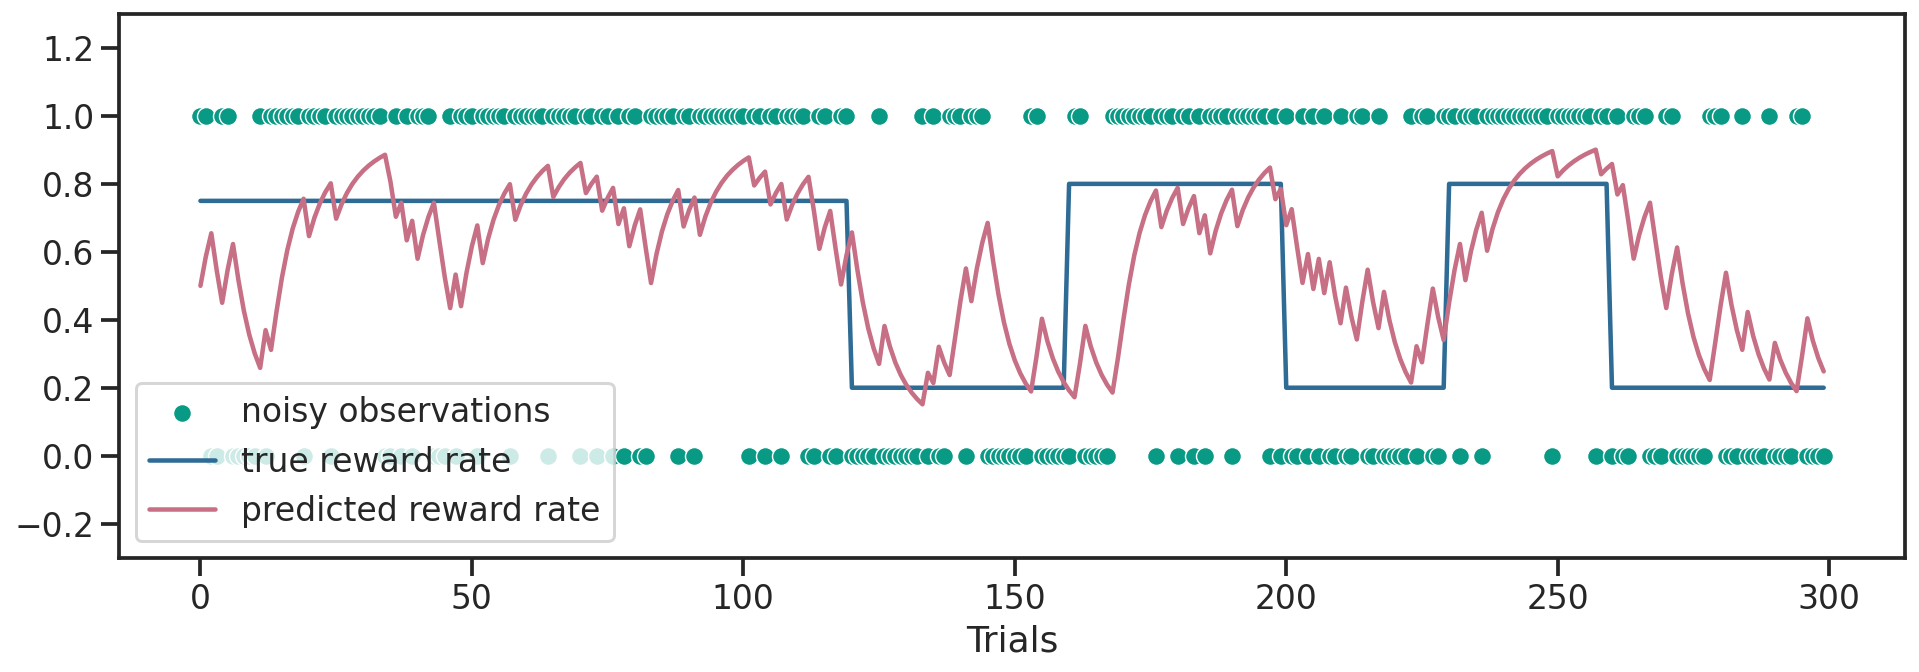

In [66]:
subj_data = {1: get_data()}
rng = np.random.default_rng(42)
subject = model(minKL)

params = [.7]
sim_data = subject.sim(subj_data, params, rng)
fig,ax=plt.subplots(1,1,figsize=(16, 5))
sns.scatterplot(x='trials', y='state', data=sim_data, 
            marker='o', color=viz.Green, 
            ax=ax, label='noisy observations')
sns.lineplot(x='trials', y='p_True', data=sim_data, 
            color=viz.Blue, 
            ax=ax, label='true reward rate')
sns.lineplot(x='trials', y='p_pred', data=sim_data, 
            color=viz.Red, 
            ax=ax, label='predicted reward rate')
ax.set_ylim([-.3, 1.3])
ax.set_ylabel('')
ax.set_xlabel('Trials')
ax.legend()
plt.show()

### The soft RL framework

<!-- According to RL as inference framework, the optimal policy should minize,

$$\min_\theta D_{\text{KL}}[\pi(a;\theta)||p(a)]$$ -->

Let $o_t$ is the feedback, $p$ is the prediction. The objective function of the soft RL model.

$$\max_\theta J(\theta) = \max_\theta \pi(a_t;\theta)[r(a_t) - b]$$

A reasonable choice is $b= \frac{1}{2}$

The gradient follows,

$$
\bigtriangledown_{\theta} J(\theta) = -\pi(a_t)\left[\mathbb{I}(a_t) - \sum_{a'} \mathbb{I}(a') \pi(a')\right](r(a_t) - b)
$$

The update rule is, 

$$\theta = \theta - \alpha\bigtriangledown_{\theta} J(\theta)$$

In [97]:
class softRL(baseAgent):
    '''Soft RL'''
    name     = 'Soft RL'
    bnds     = [(0, 1), (0, 60)]
    pbnds    = [(0, 1), (0, 60)]
    p_name   = ['α_v', 'α_θ']
    n_params = len(bnds)
    voi      = ['p'] 

    def load_params(self, params): 
        self.alpha = params[0]

    def _init_Believes(self):
        self._init_Actor()

    def _init_Actor(self):
        self.theta = 0
        self.p = 1 / (1 + np.exp(-self.theta))
        self.pi_A = np.array([self.p, 1-self.p])

    def _learnActor(self):
        o =  self.buffer.sample('corAct')
        # predict
        grad = (np.log(self.p) - np.log(o+eps_))*self.p*(1-self.p) - (np.log(1-self.p) - np.log(1-o+eps_))*self.p*(1-self.p)
        self.theta -= self.alpha * grad 
        self.p = 1 / (1 + np.exp(-self.theta))
        self.pi_A = np.array([self.p, 1-self.p])

    def learn(self):
        self._learnActor()

    def _policy(self):
        return self.pi_A

    def print_p(self):
        return self.p.copy()

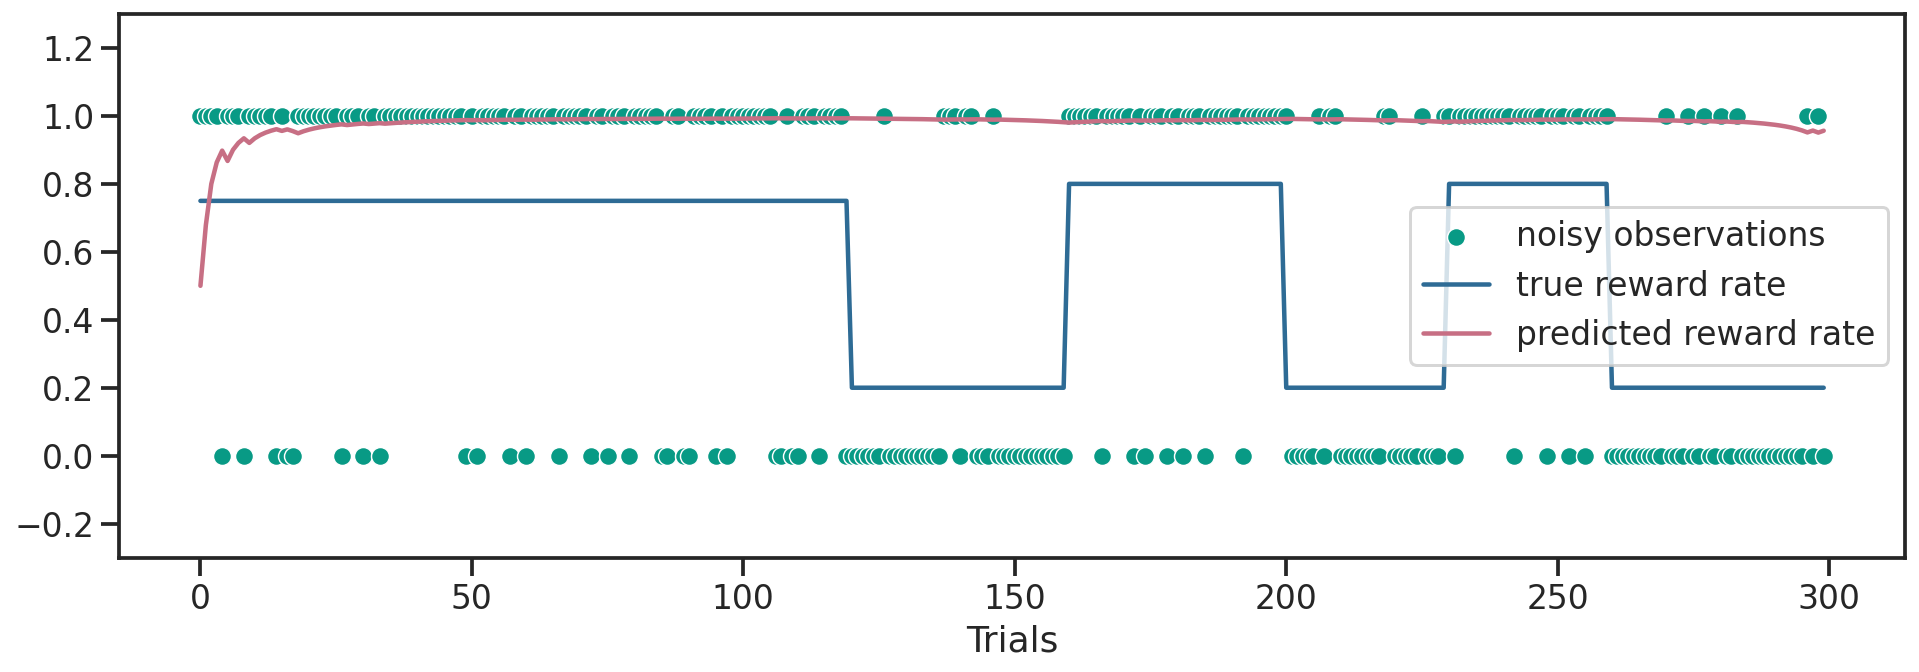

In [101]:
subj_data = {1: get_data()}
rng = np.random.default_rng(42)
subject = model(softRL)

params = [.1]
sim_data = subject.sim(subj_data, params, rng)
fig,ax=plt.subplots(1,1,figsize=(16, 5))
sns.scatterplot(x='trials', y='state', data=sim_data, 
            marker='o', color=viz.Green, 
            ax=ax, label='noisy observations')
sns.lineplot(x='trials', y='p_True', data=sim_data, 
            color=viz.Blue, 
            ax=ax, label='true reward rate')
sns.lineplot(x='trials', y='p_pred', data=sim_data, 
            color=viz.Red, 
            ax=ax, label='predicted reward rate')
ax.set_ylim([-.3, 1.3])
ax.set_ylabel('')
ax.set_xlabel('Trials')
ax.legend()
plt.show()

In [91]:
theta = torch.zeros([1,]).requires_grad_()
data = [0, 1, 0, 1, 1, 1, 1, 0]
alpha = .1 

for y in data:
    p = torch.sigmoid(theta)
    y_t = torch.tensor(y)
    L = p*p.log() + (1-p)*(1-p).log() - p*(y_t+eps_).log() - (1-p)*(1-y_t+eps_).log()
    L.backward()
    print(f'auto: {theta.grad.data.numpy()}')
    p_data = p.data.numpy()
    grad = -(np.log(p_data) - np.log(y+eps_))*p_data*(1-p_data) + (np.log(1-p_data) - np.log(1-y+eps_))*p_data*(1-p_data)
    print(f'hand: {grad}')
    theta.data -= alpha * theta.grad.data
    theta.grad.data.zero_()

auto: [7.483402]
hand: [-7.483402]
auto: [-6.689416]
hand: [6.6894164]
auto: [7.451802]
hand: [-7.451802]
auto: [-6.5174775]
hand: [6.5174766]
auto: [-7.4706817]
hand: [7.4706817]
auto: [-6.7665315]
hand: [6.766532]
auto: [-4.9626646]
hand: [4.9626646]
auto: [4.003871]
hand: [-4.003871]


In [51]:
np.log(0.4875)

-0.7184649885442352